这里尝试利用autograd计算对数似然函数的Hessian矩阵，并计算Fisher信息阵，比较渐进正态（无论是贝叶斯意义上的还是频率主义的），数值积分（特别是那个书上提到的数值积分方法）与Laplace近似之间的关系。

In [1]:
import autograd.numpy as np  

In [2]:
from autograd import grad,hessian,jacobian

In [3]:
import autograd

In [4]:
def quad(x):
    return x.T @ np.array([[2.,1.],[1.,2.]]) @ x

In [5]:
quad(np.array([1,2]))

14.0

In [6]:
hess_quad = autograd.hessian(quad)

In [7]:
hess_quad(np.array([1.,2.]))

array([[4., 2.],
       [2., 4.]])

In [8]:
# 原书数据，不过好像有问题就不用了。
#days = np.array([21, 24, 25, 26, 28, 31, 33, 34, 35, 37, 43, 49, 51, 55, 25, 29, 43, 44, 46, 46, 51, 55, 56, 58],dtype=np.float32)
#response = np.array([1]*14 + [0]*10,dtype=np.float32)

In [9]:
#days = np.array([11, 16, 20, 20, 21, 24, 25, 26, 28, 31, 33, 34, 35, 37, 43, 49, 51, 55, 20, 20, 25, 29, 43, 44, 46, 46, 51, 55, 56, 58, 72],dtype=np.float32)
#response = np.array([1]*18 + [0]*13,dtype=np.float32)

In [10]:
def loglikelihood(params):
    alpha, beta = params
    return np.sum(y * (alpha + beta * x) - np.log(1.+np.exp(alpha+beta*x)))

In [11]:
hess_loglikelihood = hessian(loglikelihood)
grad_loglikelihood = grad(loglikelihood)

In [12]:
def exact_grad_loglikelihood(params):
    alpha,beta = params
    P = np.exp(alpha+beta*x)/(1.+np.exp(alpha+beta*x))
    return np.array([np.sum(y-P), np.sum(x*(y-P))])

def exact_hess_loglikelihood(params):
    alpha, beta = params
    P = np.exp(alpha+beta*x)/(1.+np.exp(alpha+beta*x))
    return np.array([[-np.sum(P*(1-P)),-np.sum(x*P*(1-P))],
                     [-np.sum(x*P*(1-P)),-np.sum(x**2*P*(1-P))]])

In [13]:
def newton_raphson(f, x0, grad, hess, n_iter, verbose=True):
    x = x0
    for i in range(n_iter):
        if verbose:
            print(x)
        x = x + np.linalg.inv(-hess(x)) @ grad(x)
    return x

def newton_raphson_1d(f, x0, grad, hess, n_iter, verbose=True):
    x = x0
    for i in range(n_iter):
        if verbose:
            print(x)
        x = x + 1./(-hess(x)) * grad(x)
    return x

In [14]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [15]:
spector_data = sm.datasets.spector.load()


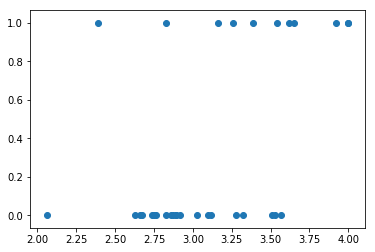

In [16]:
plt.scatter(spector_data.exog[:,0], spector_data.endog)

In [17]:
x = spector_data.exog[:,0]
x = np.vstack([np.ones_like(x),x]).T
x.shape

(32, 2)

In [18]:
x[:3,:]

array([[1.  , 2.66],
       [1.  , 2.89],
       [1.  , 3.28]])

In [19]:
logit_mod = sm.Logit(spector_data.endog, x)
logit_res = logit_mod.fit(disp=0)
print('Parameters: ', logit_res.params)


Parameters:  [-9.70319229  2.84006002]


In [20]:
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:                          Logit   Df Residuals:                       30
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Dec 2018   Pseudo R-squ.:                  0.2128
Time:                        17:58:24   Log-Likelihood:                -16.209
converged:                       True   LL-Null:                       -20.592
                                        LLR p-value:                  0.003070
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7032      3.671     -2.643      0.008     -16.898      -2.508
x1             2.8401      1.127      2.520      0.012       0.631       5.049
==============================================================================
"""

In [21]:
x = spector_data.exog[:,0]
y = spector_data.endog

In [22]:
newton_raphson(loglikelihood, np.array([0.1,0.1]), exact_grad_loglikelihood, exact_hess_loglikelihood, 4)

[0.1 0.1]
[-7.2871188   2.12754974]
[-9.37246301  2.74297315]
[-9.69616043  2.83800321]


array([-9.70318902,  2.84005907])

In [23]:
newton_raphson(loglikelihood, np.array([0.1,0.1]), exact_grad_loglikelihood, exact_hess_loglikelihood, 10)

[0.1 0.1]
[-7.2871188   2.12754974]
[-9.37246301  2.74297315]
[-9.69616043  2.83800321]
[-9.70318902  2.84005907]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]


array([-9.70319229,  2.84006002])

In [24]:
hat_theta = newton_raphson(loglikelihood, np.array([0.1,0.1]), grad_loglikelihood, hess_loglikelihood, 10)
hat_theta

[0.1 0.1]
[-7.2871188   2.12754974]
[-9.37246301  2.74297315]
[-9.69616043  2.83800321]
[-9.70318902  2.84005907]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]
[-9.70319229  2.84006002]


array([-9.70319229,  2.84006002])

Observed Fisher information matrix

$$
I(\hat{\theta} \mid Y) =  -\frac{\partial^2 l(\theta \mid Y)}{\partial \theta^2} \Big|_\hat{\theta}
$$

In [25]:
I = -exact_hess_loglikelihood(hat_theta)
I

array([[ 5.34385706, 17.28619571],
       [17.28619571, 56.7043715 ]])

In [26]:
I = -hess_loglikelihood(hat_theta)
I

array([[ 5.34385706, 17.28619571],
       [17.28619571, 56.7043715 ]])

In [27]:
C = np.linalg.inv(I)
C

array([[13.47699445, -4.1084304 ],
       [-4.1084304 ,  1.27008077]])

Expected Fisher information matrix
$$
J(\theta) = E\left(-\frac{\partial^2 l(\theta \mid Y)}{\partial \theta^2} \middle| \theta \right)
$$

特别地，我们考虑期望费舍尔信息阵在$\hat{\theta}$处的估计值:

$$
\hat{J}(\hat{\theta}) = \frac{1}{n} \sum_{i=1}^n \left(-\frac{\partial^2 l(\theta \mid Y_i)}{\partial \theta^2} \middle| \hat{\theta} \right)
$$

In [28]:
_x = x
_y = y
hess_list = []
for i in range(_y.shape[0]):
    x = _x[i]
    y = _y[i]
    hess_list.append(-hess_loglikelihood(hat_theta))
J = np.array(hess_list).mean(0)
x = _x
y = _y
J

array([[0.16699553, 0.54019362],
       [0.54019362, 1.77201161]])

In [29]:
np.linalg.inv(J)

array([[ 431.26382236, -131.46977275],
       [-131.46977275,   40.6425847 ]])

EMMM，那么算好像不对，还是应该用一次实验，但由n个样本那种(那就是Observed information matrix)，这和n次实验，每次一个样本看起来不等价。

In [30]:
def likelihood(params):
    return np.exp(loglikelihood(params))

In [31]:
def trapezoidal_rule(f, left, right, m):
    xs = np.linspace(left, right, m, True)
    ys = np.empty_like(xs)
    for i,x in enumerate(xs):
        ys[i] = f(x)
    ys[0] /= 2
    ys[-1] /=2
    return (right - left)/m * np.sum(ys)

In [32]:
trapezoidal_rule(lambda alpha: likelihood([alpha, 2.8]), -20, 0, 100)

9.81451256937128e-08

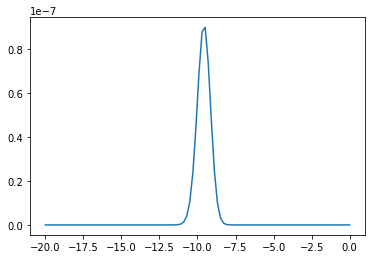

In [33]:
plt.plot(np.linspace(-20,0,100,True),[likelihood([alpha,2.8]) for alpha in np.linspace(-20,0,100,True)])

In [34]:
betas = np.linspace(-12,16,200)
p_betas = np.array([trapezoidal_rule(lambda alpha: likelihood([alpha, beta]), -20, 0, 100) for beta in betas])
p_betas.sum()

2.0321935618951474e-06

In [35]:
step = betas[1] - betas[0]
w = np.ones_like(p_betas)
w[0] = w[-1] = 0.5
p_betas = p_betas / np.sum(p_betas * w * step)
p_betas.sum()

7.107142857142893

In [36]:
p_betas

array([7.09108492e-192, 1.43914314e-189, 2.92075614e-187, 5.92770529e-185,
       1.20303402e-182, 2.44157019e-180, 4.95519238e-178, 1.00566150e-175,
       2.04100060e-173, 4.14223217e-171, 8.40670374e-169, 1.70614936e-166,
       3.46264807e-164, 7.02748067e-162, 1.42623459e-159, 2.89455810e-157,
       5.87453609e-155, 1.19224328e-152, 2.41967026e-150, 4.91074623e-148,
       9.96641109e-146, 2.02269361e-143, 4.10507793e-141, 8.33129879e-139,
       1.69084584e-136, 3.43158939e-134, 6.96444668e-132, 1.41344176e-129,
       2.86859486e-127, 5.82184330e-125, 1.18154918e-122, 2.39796639e-120,
       4.86669773e-118, 9.87701346e-116, 2.00455006e-113, 4.06825486e-111,
       8.25656446e-109, 1.67567801e-106, 3.40080496e-104, 6.90196616e-102,
       1.40076039e-099, 2.84285544e-097, 5.76959810e-095, 1.17094408e-092,
       2.37643801e-090, 4.82299109e-088, 9.78826976e-086, 1.98652808e-083,
       4.03164727e-081, 8.18217973e-079, 1.66055645e-076, 3.37004483e-074,
       6.83933814e-072, 1

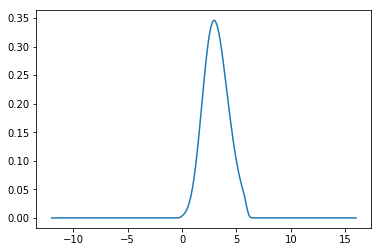

In [37]:
plt.plot(betas, p_betas)

In [38]:
import scipy.stats as stats

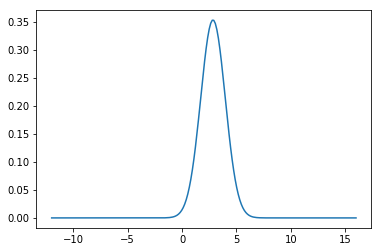

In [39]:
plt.plot(betas,stats.norm(hat_theta[1], np.sqrt(C[1,1])).pdf(betas))

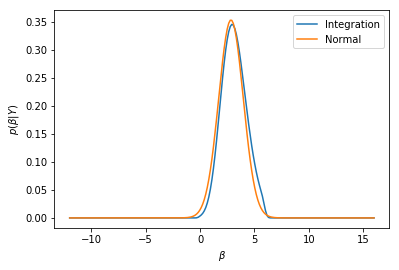

In [40]:
plt.plot(betas, p_betas, label='Integration')
plt.plot(betas, stats.norm(hat_theta[1], np.sqrt(C[1,1])).pdf(betas), label='Normal')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$p(\beta|Y)$')
plt.legend()
plt.show()

In [41]:
betas1 = betas
p_betas_integration = p_betas
p_betas_normal = stats.norm(hat_theta[1], np.sqrt(C[1,1])).pdf(betas)

当统计量被近似为正态分布时，Delta方法可以进一步得到它们函数的分布。

In [42]:
def odd(params):
    alpha,beta = params
    return -alpha/beta

In [43]:
grad_odd = grad(odd)

In [44]:
grad_odd([1.,1.])

[array(-1.), array(1.)]

In [45]:
grad_odd(hat_theta)

array([-0.35210523, -1.20298331])

In [46]:
odd_normal_approx_mean = odd(hat_theta)
odd_normal_approx_std = np.sqrt(grad_odd(hat_theta).T @ C @ grad_odd(hat_theta))

In [47]:
odd_normal_approx_mean

3.4165447970668836

In [48]:
odd_normal_approx_std

0.16853037367101031

In [49]:
grid_like = np.empty([100,100])
grid_odd = np.empty([100,100])
alpha_space = np.linspace(-20,0,100)
beta_space = np.linspace(-10,10,100)
for i,alpha in enumerate(alpha_space):
    for j,beta in enumerate(beta_space):
        grid_like[i,j] = likelihood([alpha, beta])
        grid_odd[i,j] = odd([alpha,beta])

In [50]:
np.sum(grid_like)

7.083803027854572e-06

In [51]:
w = np.ones([100,100]) * 0.5
w[1:-1,1:-1] = 1 
step = (alpha_space[1] - alpha_space[0]) * (beta_space[1] - beta_space[0])

In [52]:
grid_like /= np.sum(grid_like * w * step)
grid_like.sum()

24.526274616710317

In [53]:
np.sum(grid_odd * grid_like)

84.5774831906883

突然发现直接那么算要么只能算moment之类的函数，要么只能直方近似。要想算函数的分布还是得用他那个变换方法（因为不是可逆变换）

可逆变换的密度函数$Y = g(X)$：

$$
f_Y(y) = \frac{f_X(x)}{ \left| \det \frac{\partial g(x)}{\partial x} \right|} \Big|_{x = g^{-1}(y)} 1(y \in R_Y)
$$

$R(y)$为使$y=g(x)$的$x$不为0的集合。

In [54]:
def g(params):
    alpha,beta = params
    rho = -alpha/beta
    return np.array([rho, alpha])

def g_inv(params):
    rho, alpha = params
    beta = -1./rho * alpha
    return np.array([alpha, beta])

In [55]:
jacc_g = jacobian(g)

In [56]:
jacc_g(hat_theta)

array([[-0.35210523, -1.20298331],
       [ 1.        ,  0.        ]])

In [57]:
def likelihood_g(params):
    inv_params = g_inv(params)
    return likelihood(inv_params)/np.abs(np.linalg.det(jacc_g(inv_params)))
    

In [58]:
odd(hat_theta)

3.4165447970668836

In [126]:
#rhos = np.linspace(-7,13,100,True)
rhos = np.linspace(2.,5.,100,True)
p_rhos = np.empty_like(rhos)
alpha_space = np.linspace(-15,-5,100,True)
w = np.ones_like(alpha_space) * 0.5
w[1:-1] = 1.
for i, rho in enumerate(rhos):
    like_list = [likelihood_g(np.array([rho, alpha])) for alpha in alpha_space]
    p_rhos[i] = np.sum(np.array(like_list) * w)

In [127]:
p_rhos

array([1.20923329e-23, 9.21708480e-23, 6.46434431e-22, 4.18364934e-21,
       2.50548901e-20, 1.39220216e-19, 7.19640254e-19, 3.46922004e-18,
       1.56359629e-17, 6.60455994e-17, 2.62071666e-16, 9.79190597e-16,
       3.45291671e-15, 1.15177354e-14, 3.64244842e-14, 1.09457170e-13,
       3.13255082e-13, 8.55730528e-13, 2.23640446e-12, 5.60453968e-12,
       1.34997451e-11, 3.13293184e-11, 7.02247710e-11, 1.52424548e-10,
       3.21216733e-10, 6.59049405e-10, 1.32023701e-09, 2.58975433e-09,
       4.98854137e-09, 9.46069689e-09, 1.77001945e-08, 3.26999605e-08,
       5.96141807e-08, 1.06967488e-07, 1.88049424e-07, 3.21951537e-07,
       5.33223244e-07, 8.48859543e-07, 1.29177155e-06, 1.87132715e-06,
       2.57362384e-06, 3.35572060e-06, 4.14776027e-06, 4.86426925e-06,
       5.42197216e-06, 5.75832746e-06, 5.84448947e-06, 5.68879221e-06,
       5.33072891e-06, 4.82872358e-06, 4.24636437e-06, 3.64107046e-06,
       3.05727024e-06, 2.52420242e-06, 2.05716615e-06, 1.66062372e-06,
      

In [128]:
w = np.ones_like(p_rhos) * 0.5
w[1:-1] = 1.
p_rhos = p_rhos/ np.sum(p_rhos * w * (rhos[1] - rhos[0]))
p_rhos.sum()

33.00005185834298

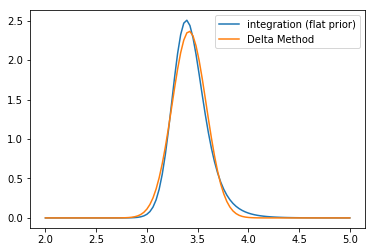

In [129]:
plt.plot(rhos, p_rhos, label='integration (flat prior)')
plt.plot(rhos, stats.norm(odd_normal_approx_mean, odd_normal_approx_std).pdf(rhos), label='Delta Method')
plt.legend()
plt.show()

In [130]:
rhos1 = rhos
p_rhos_delta = stats.norm(odd_normal_approx_mean, odd_normal_approx_std).pdf(rhos)
p_rhos_int = p_rhos

# Laplace's Method

Laplace's method本身指一种利用多项式增长被指数下降控制的积分的近似（如正态分布的多项式函数，不过正态分布的多项式函数的积分有类似，但更有效的方法。）如：

$$
I = \int f(\theta) \exp (-nh(h(\theta))) d\theta
$$

可被近似为：

$$
\hat{I} = f(\hat{\theta}) \sqrt{\frac{2\pi}{n}} \sigma \exp(-nh(\hat{\theta}))
$$

where
$$
\sigma = \left[ \frac{\partial^2 h}{\partial \theta^2} \middle|_{\hat{\theta}} \right]^{-1/2}
$$

而$\hat{\theta}$为使得$-h(\theta)$最大化的$\theta$

积分中涉及的指数型函数$\exp(-nh(\theta))$可以直接导出一个分布，由：

$$
p(\theta) = \frac{\exp(-nh(\theta))}{\int \exp(-nh(\theta))d\theta}
$$

其中$n$一般指密度函数独立乘积时产生出的项。可以进一步得到它们的误差水平等。

$$
E(g(\theta)) = \frac{\int g(\theta)\exp(-nh(\theta)) d\theta}{\int \exp(-nh(\theta))d\theta} = g(\hat{\theta})(1+O(1/n))
$$

也有一些更细致的结果，但更令人感兴趣的是它如何用于分布边缘化的近似（边缘化显然就是一种积分，而Laplace's method就是找简单的积分近似表示），可以得到(Tierney and Kadane 1986, Accurate approximation for posterior moments and marginal densities)

$$
\hat{p}(\theta_1 \mid Y) \propto (\det \hat{\Sigma}^*)^{1/2} p(\theta_1,\hat{\theta}_2^* \mid Y)
$$

其中直接在完全后验中把本来要积掉的$\theta_2$向量直接换成它的对应固定$\theta_1$的极大后验$\theta_2^*(\theta_1)$称为profile posterior。
某种意义上说这也算是一种边缘化，不过它需要

$$
\hat{\Sigma}^* = \left[ \frac{-\partial^2 \log p(\theta_1,\theta_2 \mid Y)}{\partial \theta_2^2} \middle|_{\hat{\theta}_2^*} \right]^{-1}
$$

项的修正。这样得到$\theta_1$的边缘后验概率$p(\theta_1 \mid Y)$从完全后验概率$p(\theta_1,\theta_2 \mid Y)$中

In [63]:
p_betas

array([7.09108492e-192, 1.43914314e-189, 2.92075614e-187, 5.92770529e-185,
       1.20303402e-182, 2.44157019e-180, 4.95519238e-178, 1.00566150e-175,
       2.04100060e-173, 4.14223217e-171, 8.40670374e-169, 1.70614936e-166,
       3.46264807e-164, 7.02748067e-162, 1.42623459e-159, 2.89455810e-157,
       5.87453609e-155, 1.19224328e-152, 2.41967026e-150, 4.91074623e-148,
       9.96641109e-146, 2.02269361e-143, 4.10507793e-141, 8.33129879e-139,
       1.69084584e-136, 3.43158939e-134, 6.96444668e-132, 1.41344176e-129,
       2.86859486e-127, 5.82184330e-125, 1.18154918e-122, 2.39796639e-120,
       4.86669773e-118, 9.87701346e-116, 2.00455006e-113, 4.06825486e-111,
       8.25656446e-109, 1.67567801e-106, 3.40080496e-104, 6.90196616e-102,
       1.40076039e-099, 2.84285544e-097, 5.76959810e-095, 1.17094408e-092,
       2.37643801e-090, 4.82299109e-088, 9.78826976e-086, 1.98652808e-083,
       4.03164727e-081, 8.18217973e-079, 1.66055645e-076, 3.37004483e-074,
       6.83933814e-072, 1

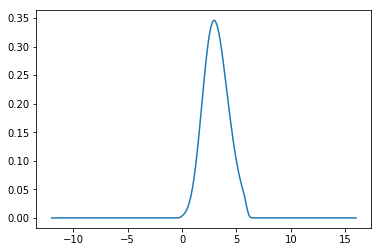

In [64]:
plt.plot(betas,p_betas)

In [65]:
def square(x):
    return (x-1.)**2
def pow4(x):
    return (x-2.)**4

In [66]:
grad_square = grad(square)
hess_square = hessian(square)

In [67]:
grad_square(0.)

-2.0

In [68]:
hess_square(0.)

array(2.)

In [69]:
newton_raphson_1d(square, 0., grad_square, hess_square, 5)

0.0
1.0
1.0
1.0
1.0


1.0

In [70]:
newton_raphson_1d(pow4, 0., grad(pow4), hessian(pow4), 10)

0.0
0.6666666666666666
1.1111111111111112
1.4074074074074074
1.6049382716049383
1.7366255144032923
1.8244170096021948
1.8829446730681298
1.9219631153787533
1.9479754102525022


1.9653169401683348

In [71]:
f=lambda alpha:loglikelihood([alpha, 2.5])
newton_raphson_1d(f, 0., grad(f), hessian(f), 10)

0.0
-861.2442634178011
-inf
-inf
-inf
-inf
-inf
-inf
-inf
-inf


D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
D:\anaconda\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in multiply
  return f_raw(*args, **kwargs)


-inf

In [72]:
f=lambda alpha:loglikelihood([alpha, 2.5])
newton_raphson_1d(f, -7., grad(f), hessian(f), 10)

-7.0
-8.661452561570277
-8.603909251528046
-8.604280816173121
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144


-8.604280831212144

看样子这数值相当不稳定，下面先按1步长搜索最优值，再在其基础上用牛顿法优化找到最优值。

In [73]:
f=lambda alpha:loglikelihood([alpha, 2.5])
alphas = np.linspace(-20.,-0.1,20)
likes = np.array([ f(alpha) for alpha in alphas])
alpha_rough = alphas[np.argmax(likes)]
alpha_rough


-8.478947368421053

In [74]:
newton_raphson_1d(f, alpha_rough, grad(f), hessian(f), 10)

-8.478947368421053
-8.602729146884332
-8.60428056919145
-8.604280831212137
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144
-8.604280831212144


-8.604280831212144

In [75]:
betas = np.linspace(-4.5,10.5,150)
p_betas = np.empty_like(betas)
for i,beta in enumerate(betas):
    f=lambda alpha:loglikelihood([alpha, beta])
    alphas = np.linspace(-30.,10.1,40)
    likes = np.array([ f(alpha) for alpha in alphas])
    alpha_rough = alphas[np.argmax(likes)]
    alpha = newton_raphson_1d(f, alpha_rough, grad(f), hessian(f), 10, verbose=False)
    sigma = 1./-hess_loglikelihood(np.array([alpha, beta]))[0,0]
    #sigma = np.linalg.inv(-hess_loglikelihood(np.array([alpha, beta])))[0,0]
    p_betas[i] = np.sqrt(sigma) * likelihood([alpha, beta])

In [76]:
w = np.ones_like(p_betas) * 0.5
w[1:-1] = 1.

p_betas = p_betas / np.sum(p_betas * w * (betas[1] - betas[0]) )
p_betas.sum()

9.93333913760473

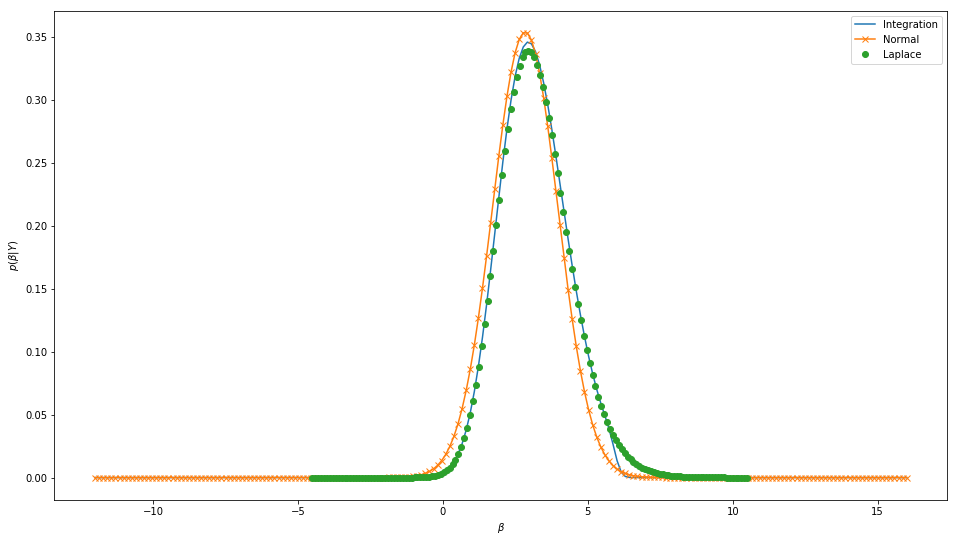

In [77]:
plt.figure(figsize=(16,9))

plt.plot(betas1, p_betas_integration, label='Integration')
plt.plot(betas1, p_betas_normal,'-x',label='Normal')
plt.plot(betas, p_betas, 'o',label='Laplace')

plt.xlabel(r'$\beta$')
plt.ylabel(r'$p(\beta|Y)$')
plt.legend()
plt.show()


边缘化可以看成构造出一个随机变量的函数后，把所有原随机变量全部积掉的特例，所以Laplace's method也有一般函数（marginal of an arbitrary function）的版本(Tierney, Kass and Kadane(1989), Approximate marginal densities of nonlinear functions.)：


$$
\hat{p}(\gamma \mid Y) \propto \left[ \frac{\det [\Sigma(\gamma) ]}{\det [ (D_g)^T \Sigma(\gamma)(D_g) ]} \right]^{1/2} p(\hat{\theta}(\gamma) \mid Y)
$$

其中$\hat{\theta}(\gamma)$在符合约束$g(\theta) = \gamma$下最大化后验$p(\theta \mid Y)$的参数取值。$\Sigma(\gamma)$是在$\hat{\
theta}(\gamma)$下计算的log posterior的逆Hessian矩阵，$-(\frac{\partial^2 p(\gamma \mid Y)}{\partial \theta^2})^{-1}$（与前面的$C$,$J^{-1},I^{-1}$之类的一致。）。$D_g$为梯度（$g(\theta)$为单元函数时）或Jacobian($g(\theta)$为多元函数时)。

下面用这个方法计算$\rho=-\frac{\alpha}{\beta}$的后验分布，并于前面的正态近似（Delta方法）与数值积分法的结果作比较。

In [78]:
from scipy.optimize import minimize

In [92]:
res = minimize(lambda p:-loglikelihood(p), [-2.6,1.], constraints = [{'type': 'eq', 
                                                        'fun': lambda params: -params[0]/params[1] - 2.6}])
res

     fun: 22.07814417959998
     jac: array([ 5.95755434, 15.48967314])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([-0.60421888,  0.23239188])

In [96]:
res = minimize(lambda p:-loglikelihood(p), [-2.7,1.], constraints = [{'type': 'eq', 
                                                        'fun': lambda params: -params[0]/params[1] - 2.7}])
res.x

array([-1.23490546,  0.45737239])

In [97]:
res = minimize(lambda p:-loglikelihood(p), [-2.5,1.], constraints = [{'type': 'eq', 
                                                        'fun': lambda params: -params[0]/params[1] - 2.5}])
res.x

array([-0.20339932,  0.08135973])

In [135]:
rhos = np.linspace(2.5,4.5,100)
p_rhos = np.empty_like(rhos)
for i,rho in enumerate(rhos):
    res = minimize(lambda p:-loglikelihood(p), [-rho,1.], constraints = [{'type': 'eq', 
                                                        'fun': lambda params: -params[0]/params[1] - rho}])
    theta = res.x
    h = hess_loglikelihood(theta)
    s = -np.linalg.inv(h)
    g = grad_odd(theta)
    p = likelihood(theta)
    
    p_rhos[i] = np.sqrt(np.linalg.det(s)/(g.T @ s @ g)) * p
    

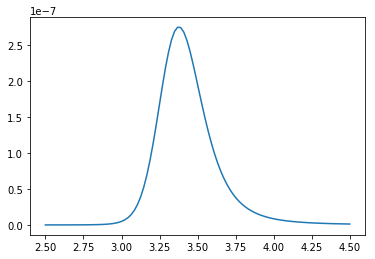

In [136]:
plt.plot(rhos,p_rhos)

In [137]:
w = np.ones_like(p_rhos) * 0.5
w[1:-1] = 1.
p_rhos = p_rhos/np.sum(p_rhos * w * (rhos[1] - rhos[0]))
p_rhos.sum()

49.50591914977484

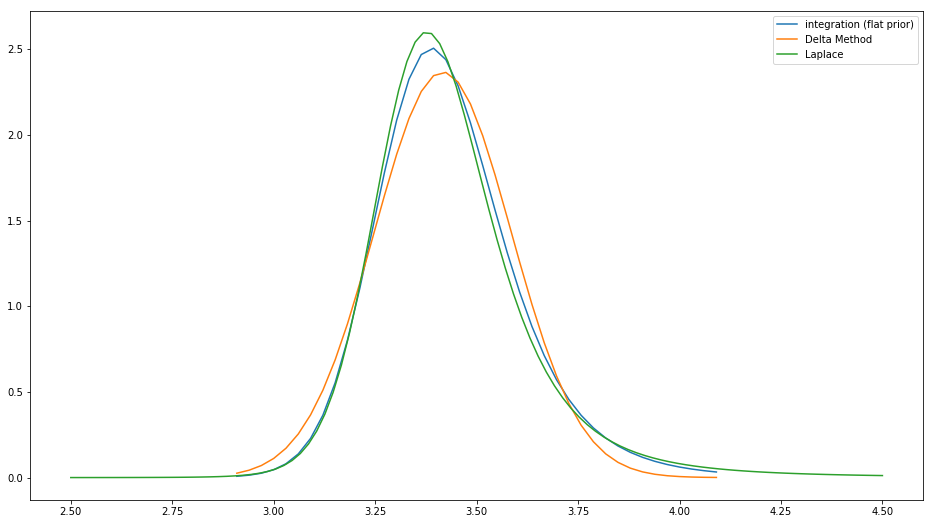

In [140]:
plt.figure(figsize=(16,9))

plt.plot(rhos1[30:-30], p_rhos_int[30:-30], label='integration (flat prior)')
plt.plot(rhos1[30:-30], p_rhos_delta[30:-30], label='Delta Method')
plt.plot(rhos, p_rhos, label='Laplace')
plt.legend()
plt.show()

In [111]:
rhos1

array([-7.        , -6.7979798 , -6.5959596 , -6.39393939, -6.19191919,
       -5.98989899, -5.78787879, -5.58585859, -5.38383838, -5.18181818,
       -4.97979798, -4.77777778, -4.57575758, -4.37373737, -4.17171717,
       -3.96969697, -3.76767677, -3.56565657, -3.36363636, -3.16161616,
       -2.95959596, -2.75757576, -2.55555556, -2.35353535, -2.15151515,
       -1.94949495, -1.74747475, -1.54545455, -1.34343434, -1.14141414,
       -0.93939394, -0.73737374, -0.53535354, -0.33333333, -0.13131313,
        0.07070707,  0.27272727,  0.47474747,  0.67676768,  0.87878788,
        1.08080808,  1.28282828,  1.48484848,  1.68686869,  1.88888889,
        2.09090909,  2.29292929,  2.49494949,  2.6969697 ,  2.8989899 ,
        3.1010101 ,  3.3030303 ,  3.50505051,  3.70707071,  3.90909091,
        4.11111111,  4.31313131,  4.51515152,  4.71717172,  4.91919192,
        5.12121212,  5.32323232,  5.52525253,  5.72727273,  5.92929293,
        6.13131313,  6.33333333,  6.53535354,  6.73737374,  6.93